In [1]:
from qiskit import *

In [2]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

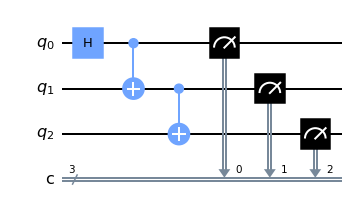

In [3]:
circuit.draw()

In [11]:
simulator = Aer.get_backend('qasm_simulator')
simu_result = execute(circuit, backend=simulator, shots = 2048).result()

In [12]:
from qiskit.tools.visualization import plot_histogram

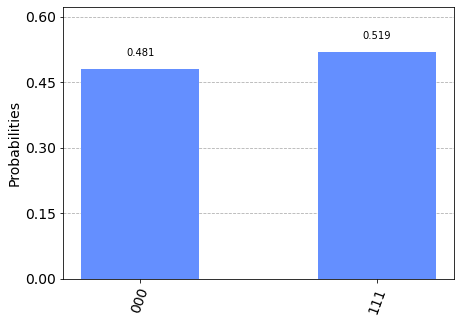

In [18]:
plot_histogram(simu_result.get_counts(circuit))

In [17]:
# now we will run this on a quantum device
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_lima')
job = execute(circuit, backend=qcomp, shots=1024)

from qiskit.tools.monitor import job_monitor

In [19]:
job_monitor(job)

Job Status: job has successfully run


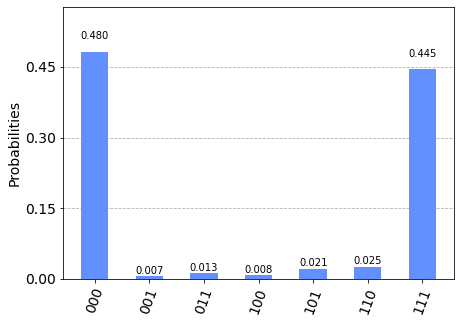

In [20]:
job_result = job.result()
plot_histogram(job_result.get_counts(circuit))

In [21]:
# we observe that we get some non-zero probability for the "unwanted" states i.e., apart from 000 and 111
# we will now try to mitigate this using ignis
from qiskit.ignis.mitigation.measurement import(complete_meas_cal, CompleteMeasFitter)

/tmp/ipykernel_114/2145616599.py:3: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import(complete_meas_cal, CompleteMeasFitter)


In [22]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

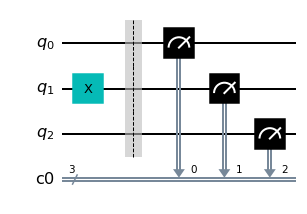

In [23]:
cal_circuits[2].draw()

In [25]:
len(cal_circuits)

8

In [26]:
# 8 was kind of expected because we can 000, 001,....... 111 which are eight in number

cal_job = execute(cal_circuits, backend = qcomp, shots=1024, optimization_level = 0)
job_monitor(cal_job)

Job Status: job has successfully run


In [27]:
cal_result = cal_job.result()

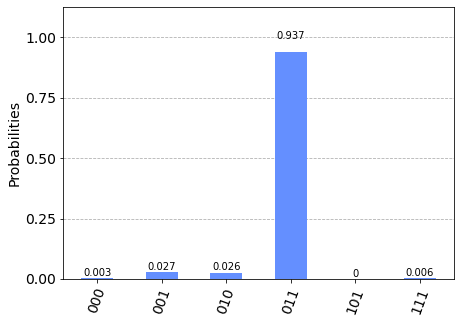

In [28]:
plot_histogram(cal_result.get_counts(cal_circuits[3]))

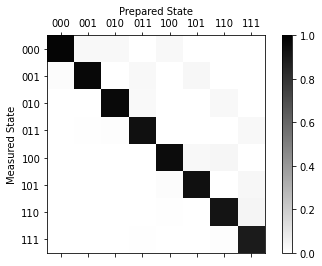

In [30]:
meas_fitter = CompleteMeasFitter(cal_result, state_labels)   # the measurement fitter extracts parameters
meas_fitter.plot_calibration()                               # from the calibration results

In [31]:
# the off-diagnol terms must be as small as possible

# now we will create a measurement filter from a fitter
meas_filter = meas_fitter.filter

In [33]:
mitigated_result = meas_filter.apply(job_result)

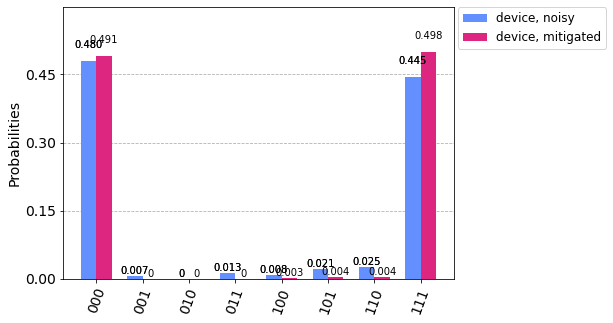

In [34]:
job_counts = job_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([job_counts, mitigated_counts], legend = ['device, noisy', 'device, mitigated'])

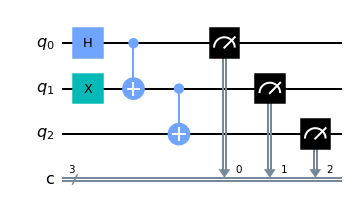

In [36]:
# notice how much improved the results are
# we have saved the measurement calibrations, etc so we can apply it to another circuits as well

circ_2 = QuantumCircuit(3, 3)
circ_2.x(1)
circ_2.h(0)
circ_2.cx(0,1)
circ_2.cx(1,2)
circ_2.measure([0,1,2], [0,1,2])
circ_2.draw()

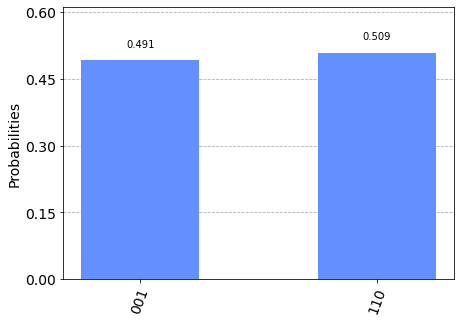

In [37]:
plot_histogram(execute(circ_2, backend=simulator, shots = 1024).result().get_counts(circ_2))

In [40]:
device_counts_2 = execute(circ_2, backend = qcomp, shots = 1024).result().get_counts(circ_2)

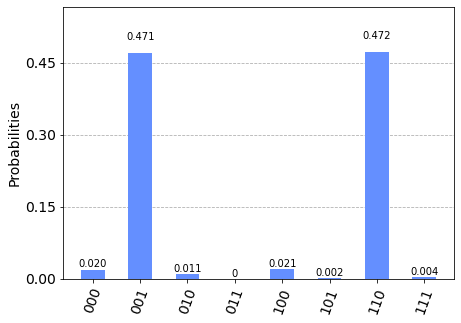

In [41]:
plot_histogram(device_counts_2)

In [43]:
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

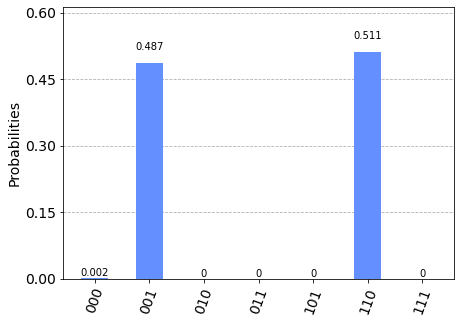

In [44]:
plot_histogram(device_mitigated_counts_2)

In [ ]:
# this is clearly so much better!!